In [192]:
import pickle

import numpyro
import numpyro.handlers as handlers
import jax.numpy as jnp
import jax
from numpyro.infer import Predictive

from src.models.M2VAE import M2VAE
from src.models.encoder_decoder import MNISTEncoder, MNISTDecoder, CIFAR10Encoder, CIFAR10Decoder
from src.data_loading.loaders import get_data_loaders

import matplotlib.pyplot as plt

In [193]:
# Set up random seed
seed = 42

# DATASET
dataset_name = "MNIST" #"MNIST" # use "CIFAR10" or "CELEBA"

p_supervised = 0.1

encoder_class = MNISTEncoder if dataset_name=="MNIST" else CIFAR10Encoder
decoder_class = MNISTDecoder if dataset_name=="MNIST" else CIFAR10Decoder
distribution = "bernoulli" if dataset_name=="MNIST" else "laplace"

cmap = "gray" if dataset_name=="MNIST" else None

In [194]:
img_shape, loader_dict, size_dict = get_data_loaders(dataset_name=dataset_name, 
                                          p_test=0.2, 
                                          p_val=0.2, 
                                          p_supervised=0.05, 
                                          batch_size=10, 
                                          num_workers=0, 
                                          seed=seed)

scale_factor = 1.

Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 12000
Num validation samples: 9600
Num supervised samples: 1920
Num unsupervised samples: 36480


In [195]:
m2_vae = M2VAE(encoder_class, 
               decoder_class, 
               10, 
               50, 
               img_shape, 
               scale_factor=scale_factor, 
               distribution=distribution
)

In [196]:
with open("./model_weights/m2vae_" + dataset_name + "_p_supervised_"+str(p_supervised)+ "_seed_"+str(seed)+".pkl", "rb") as file:
    params=pickle.load(file)

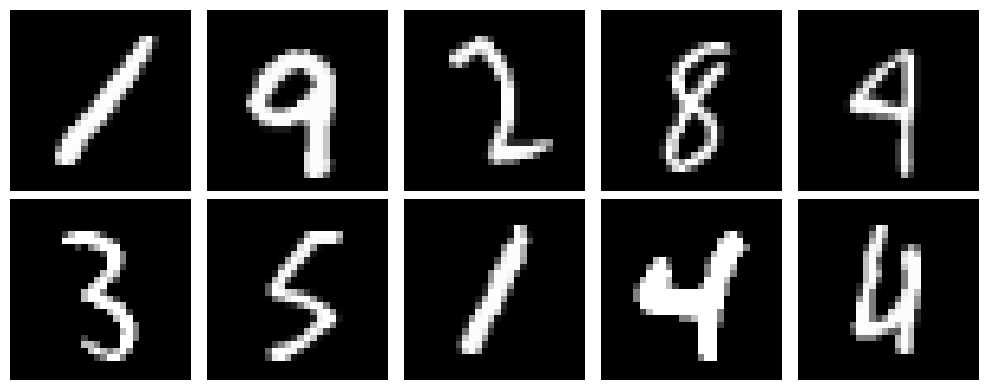

In [197]:
#xs = jnp.zeros((10,) + img_shape)
#ys = jnp.array([i for i in range(10)])


# OR 
load = iter(loader_dict["test"])
xs, ys = next(load)

n_rows = 2
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        image = xs[i * n_cols + j]
        
        if dataset_name == "MNIST":
            image = image.squeeze(-1)
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [198]:
print(xs.shape, ys.shape)

(10, 28, 28, 1) (10,)


In [199]:
predictive = Predictive(m2_vae.model_supervised, guide=m2_vae.guide_supervised, params=params, num_samples=25, return_sites=["loc", "z"])

rng_key = jax.random.PRNGKey(0) 
predictions = predictive(rng_key, xs, ys)

loc = predictions['loc']
z = predictions['z']

print(loc.shape, z.shape)

(25, 10, 28, 28, 1) (25, 10, 50)


In [200]:
class_number = 1

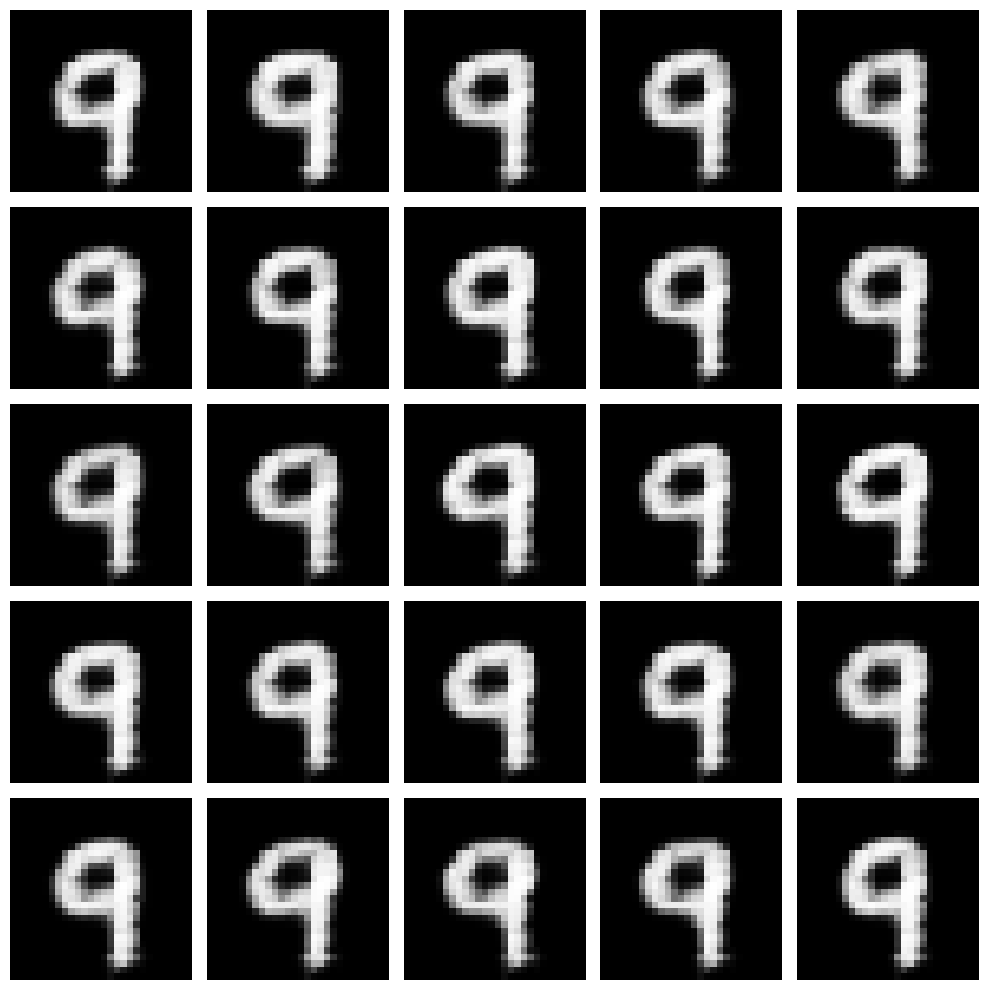

In [201]:
n_rows = 5
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = loc[i, class_number]

    if dataset_name == "MNIST":
        image = image.squeeze(-1)
        plt.imshow(image, cmap='gray')
    elif dataset_name == "CIFAR10":
        plt.imshow(image)
    plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [202]:
params.keys()

dict_keys(['decoder$params', 'encoder1$params', 'encoder2$params'])

In [203]:
class_number = 3

In [204]:
ys = jnp.ones((36,1)) * class_number
ys = jnp.eye(10)[ys.astype(int)].squeeze(1)

In [205]:
## Sample 3 random points from the latent space

z = jax.random.normal(rng_key, (3, 50))

## Construct a fourth point that is in the plane of the three points

z1 = z[0]
z2 = z[1]
z3 = z[2]
z4 = z2 + z3 - z1

## Construct a grid of barycentric weights for the 4 points

n_rows = 6
n_cols = 6

barycentric_weights = jnp.zeros((n_rows, n_cols, 4))
for i in range(n_rows):
    for j in range(n_cols):
        barycentric_weights = barycentric_weights.at[i, j, 0].set(i / (2* n_rows - 2))
        barycentric_weights = barycentric_weights.at[i, j, 1].set(j / (2* n_cols - 2))
        barycentric_weights = barycentric_weights.at[i, j, 2].set((n_cols - i) / (2* n_cols - 2))
        barycentric_weights = barycentric_weights.at[i, j, 3].set((n_rows - j) / (2* n_rows - 2))

## Construct the latent space grid
        
z_grid = jnp.zeros((n_rows, n_cols, 50))
for i in range(n_rows):
    for j in range(n_cols):
        z_grid = z_grid.at[i, j].set(barycentric_weights[i, j, 0] * z1 + barycentric_weights[i, j, 1] * z2 + barycentric_weights[i, j, 2] * z3 + barycentric_weights[i, j, 3] * z4)

In [206]:
z_grid = z_grid.reshape(-1, 50)

In [207]:
## Apply the decoder with various z's 
decoder = m2_vae.internal_decoder

loc = decoder.apply({'params' : params['decoder$params']}, z_grid, ys)

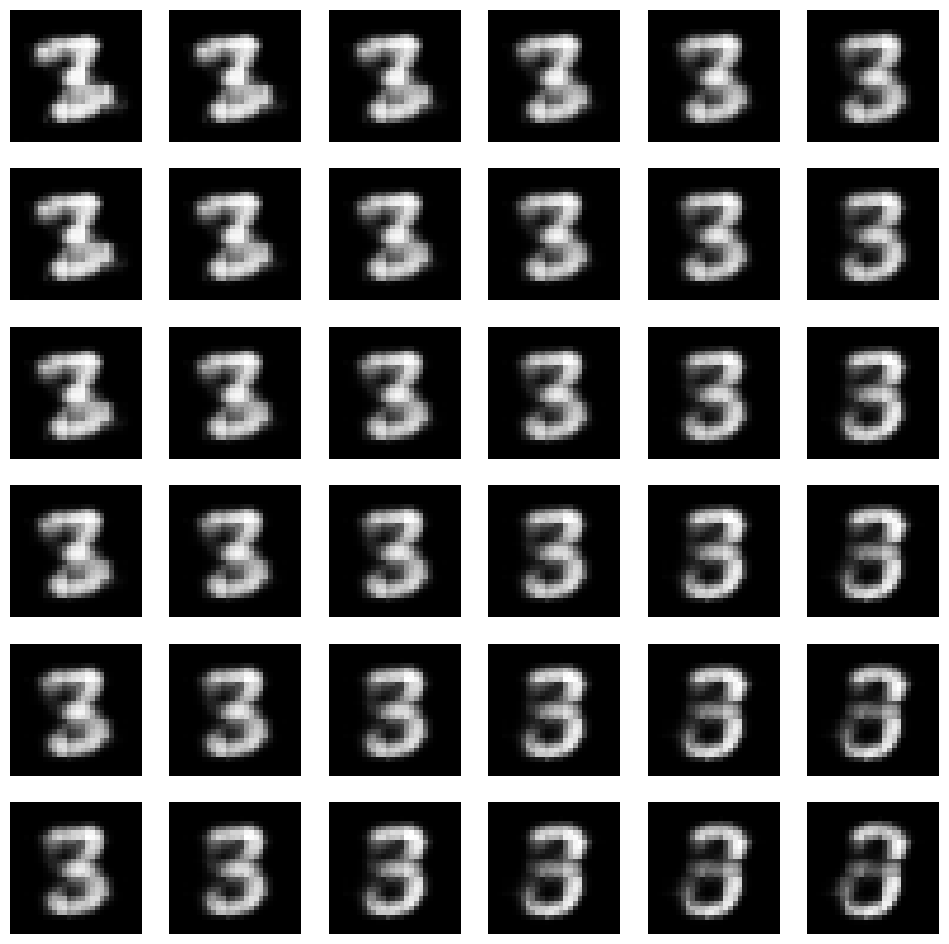

In [208]:
# Plot the generated images

n_rows = 6
n_cols = 6

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = loc[i]

    if dataset_name == "MNIST":
        image = image.squeeze(-1)
        plt.imshow(image, cmap='gray')
    elif dataset_name == "CIFAR10":
        plt.imshow(image)
    plt.axis('off')  # Turn off the axis labels

In [209]:
## Now we want to fix a style and vary the class

fixed_z = z[4] ## Correponds to the second image in the grid above with the first test batch
all_classes = jnp.eye(10)

z_grid = fixed_z.reshape(1, -1).repeat(10, axis=0)

loc = decoder.apply({'params' : params['decoder$params']}, z_grid, all_classes)

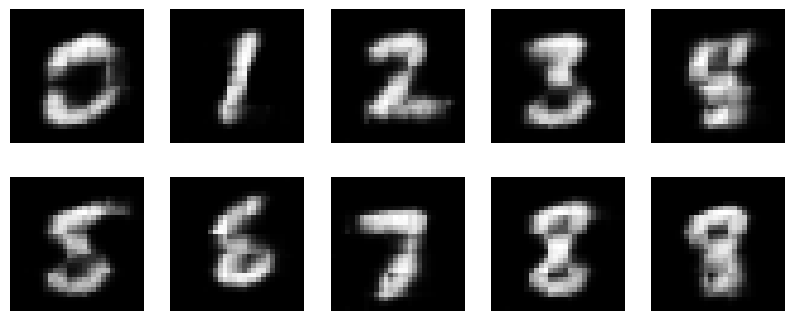

In [210]:
# Plot the generated images

n_rows = 2
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = loc[i]

    if dataset_name == "MNIST":
        image = image.squeeze(-1)
        plt.imshow(image, cmap='gray')
    elif dataset_name == "CIFAR10":
        plt.imshow(image)
    plt.axis('off')  # Turn off the axis labels